In [1]:
# default_exp simulation

# Simulation

> Classes and helper fuction for generation 3D simulation data for SMLM

In [2]:
#hide
from nbdev.showdoc import *
from fastcore.test import *
from pdb import set_trace

## 2D simulation
I am creating minimalistic example to better understand how 2d draw function - `draw_func` works in `DECODE` model. The funciton is located in https://github.com/mackelab/DECODE/blob/9d8b548d839dede798a2d2d3dbc8daa862f77c69/engine/LikelihoodModel.py#L287.

### Data preparation

In [3]:
#export 
from pathlib import Path
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
PATH = Path('/nrs/turaga/speisera/SMLM_2016/')

In [5]:
TRN_IMG_P  = PATH/'sequence-as-stack-MT0.N2.HD-AS-Exp.tif'
PSF_FILES  = Path('psf_chall_as.pkl')
SCALE      = 10
PRINT_FREQ = 500

LL_PARAMS  = {
             'p_act'   : 0.5, 
             'z_prior' : [0, 0.5],
             'surv_p'  : 0.5,
             'min_int' : 0.1,
             'p_lambda': 0.05
             }

PSF_PARAMS = {
             'modality': '3D',
             }

In [6]:
#export
def tiff_imread(path):
    '''helper function to read tiff file with pathlib object or str'''
    if isinstance(path, str) : return imread(path)
    if isinstance(path, Path): return imread(str(path))
    
    
def hasattrs(o,attrs):
    "checks of o has several attrs"
    return all(hasattr(o,attr) for attr in attrs)
     

def show_image(im, ax=None, title=None, figsize=(4, 5), **kwargs,):
    'plots image from nump or tensor'
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

In [7]:
show_doc(tiff_imread)

<h4 id="tiff_imread" class="doc_header"><code>tiff_imread</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>tiff_imread</code>(**`path`**)

helper function to read tiff file with pathlib object or str

In [8]:
show_doc(hasattrs)

<h4 id="hasattrs" class="doc_header"><code>hasattrs</code><a href="__main__.py#L8" class="source_link" style="float:right">[source]</a></h4>

> <code>hasattrs</code>(**`o`**, **`attrs`**)

checks of o has several attrs

In [9]:
show_doc(show_image)

<h4 id="show_image" class="doc_header"><code>show_image</code><a href="__main__.py#L13" class="source_link" style="float:right">[source]</a></h4>

> <code>show_image</code>(**`im`**, **`ax`**=*`None`*, **`title`**=*`None`*, **`figsize`**=*`(4, 5)`*, **\*\*`kwargs`**)

plots image from nump or tensor

In [10]:
test_eq(type(tiff_imread(TRN_IMG_P)), np.ndarray)
test_eq(type(tiff_imread(str(TRN_IMG_P))), np.ndarray)
test_eq_type(tiff_imread(TRN_IMG_P), tiff_imread(str(TRN_IMG_P)))

In [11]:
#reading TRN_IMG
TRN_IMG = tiff_imread(TRN_IMG_P)
TRN_IMG.shape

(2500, 64, 64)

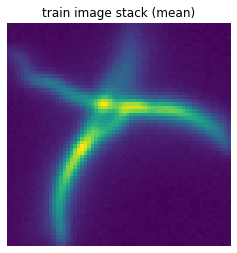

In [12]:
show_image(TRN_IMG.mean(0), title = 'train image stack (mean)');

### `draw_func`  2D
draw function is responsible for generating intial simulation ground truth data. This functions takes `M` which is normalized mean across our trainin data. We can get `M` using function `get_M` (small modification). Origiannaly `M` is `40 x 40`, since this is just for testing purpose our `M` will have dimensions of `64 x 64`. `M` gets normalized with `tanh` and `[p_act]` . 

from arthur:
>So basically the thought behind that weird  p_act * tanh( M / p_act ) is this: M is an estimate of the probability. of an emitter. So M / p_act is the probability that there is structure in that pixel. However if we update M during training this could become bigger then 1, which does not really make sense.  It can also be problematic when we do combined learning because we use lambda in the prior. So instead im using tanh( M / p_act) so it stays below 1, and then multiply again with p_act

We use normalized `M` to sample from `torch.distributions.Binomial` to generate most likely locations `locs1` of activated fluorophores. We also need x (`x_os`), y(`y_os`), and z(`z`) offsets. These offsets are sampled from `torch.distributions.Uniform` from `-0.5` to `0.5`.And lastly we need intensities `ints` which are also sampaled from  ` torch.distributions.Uniform` + `[min_int]`. Before returning the value we multiply `x_os`, `y_os`, `z` and `ints` with `locs`. 

Below I will just rewrite a little bit original `draw_func` so I can isolate the function and better understand whats hapening. Origianl `draw_func` is located here: https://github.com/mackelab/DECODE/blob/9d8b548d839dede798a2d2d3dbc8daa862f77c69/engine/LikelihoodModel.py#L287

In [13]:
def get_M(trainf, ll_pars):
    '''https://github.com/mackelab/DECODE/blob/9d8b548d839dede798a2d2d3dbc8daa862f77c69/engine/Model.py#L151'''
    map_ini = trainf.mean(0) - trainf.mean(0).min()
    map_ini /= map_ini.sum()
    map_ini *= ((ll_pars['p_act'] * ll_pars['p_lambda'] * trainf[0].size))
    train_map = map_ini.astype('float32')
    return train_map

In [14]:
test_eq(get_M(TRN_IMG, LL_PARAMS).shape, (64, 64))
test_eq(type(get_M(TRN_IMG, LL_PARAMS)), np.ndarray)

In [15]:
M = get_M(TRN_IMG, LL_PARAMS)

In [16]:
def draw_func(M, ll_pars, psf_pars, batch_size=1, local_context=False):
    λ = ll_pars['p_act'] * torch.tanh(M / ll_pars['p_act']).to('cuda')
    λ = λ.reshape(1,1,λ.shape[-2], λ.shape[-1]).repeat_interleave(batch_size, 0)
    locs1 = torch.distributions.Binomial(1, λ).sample().to('cuda')
    
    zeros = torch.zeros_like(locs1).to('cuda')

    z = torch.distributions.Normal(zeros+ll_pars['z_prior'][0], zeros+ll_pars['z_prior'][1]).sample().to('cuda')
    if '3D' in psf_pars['modality']:
        torch.tanh_(z)
        
    x_os = torch.distributions.Uniform(zeros-0.5, zeros+0.5).sample().to('cuda')
    y_os = torch.distributions.Uniform(zeros-0.5, zeros+0.5).sample().to('cuda')
    
    if 'backg_max' in ll_pars:
        bg = torch.distributions.Uniform(torch.zeros(batch_size).to('cuda')+0.01, torch.ones(batch_size).to('cuda')-0.01).sample().to('cuda')
    else:
        bg = None

    if local_context:
    
        α = ll_pars['surv_p']
        a11 = 1 - (1 - λ) * (1 - α)

        locs2 = torch.distributions.Binomial(1, (1 - locs1) * λ + locs1 * a11).sample().to('cuda')
        locs3 = torch.distributions.Binomial(1, (1 - locs2) * λ + locs2 * a11).sample().to('cuda')

        locs = torch.cat([locs1, locs2, locs3], 1)
        
        x_os = x_os.repeat_interleave(3,1)
        y_os = y_os.repeat_interleave(3,1)
        z = z.repeat_interleave(3,1)
 
    else:
        locs = locs1            
    ints = torch.distributions.Uniform(torch.zeros_like(locs)+ll_pars['min_int'], torch.ones_like(locs)).sample().to('cuda')

    x_os *= locs
    y_os *= locs
    z *= locs
    ints *= locs
    return locs,x_os,y_os,z,ints,bg

In [17]:
locs, x_os, y_os, z, ints, _ = draw_func(torch.tensor(M), LL_PARAMS, PSF_PARAMS)

In [18]:
list(map(lambda x: getattr(x, 'size')(), [locs, x_os, y_os, z, ints]))

[torch.Size([1, 1, 64, 64]),
 torch.Size([1, 1, 64, 64]),
 torch.Size([1, 1, 64, 64]),
 torch.Size([1, 1, 64, 64]),
 torch.Size([1, 1, 64, 64])]

In [19]:
sz = (64, 64)

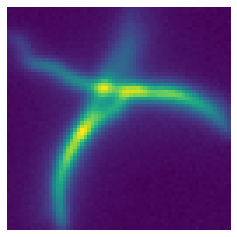

In [20]:
show_image(M)

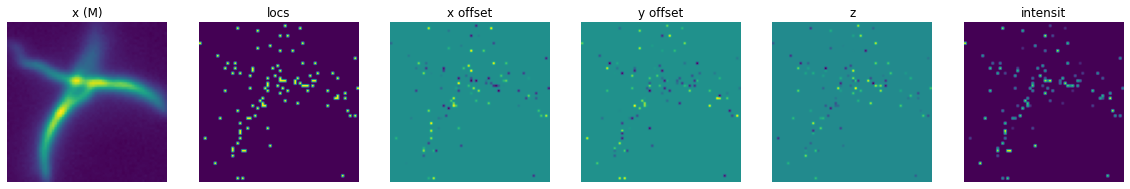

In [21]:
fig, axes = plt.subplots(1, 6, figsize=(20, 20))

show_image(torch.tensor(M).view(*sz), title= 'x (M)'   , ax = axes[0])
show_image(locs           .view(*sz), title= 'locs'    , ax = axes[1])
show_image(x_os           .view(*sz), title= 'x offset', ax = axes[2])
show_image(y_os           .view(*sz), title= 'y offset', ax = axes[3])
show_image(z              .view(*sz), title= 'z'       , ax = axes[4])
show_image(ints           .view(*sz), title= 'intensit', ax = axes[5]);

## 3D simulation

In [22]:
TRN_IMG_3D_P = Path('/nrs/turaga/smlm_data/SvobodaWang_mFISH/sample.ALM.tif')

In [23]:
TRN_IMG_3D = tiff_imread(TRN_IMG_3D_P); TRN_IMG_3D.shape

(101, 3, 960, 960)

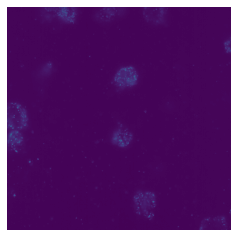

In [24]:
show_image(TRN_IMG_3D[:, 1, ::][0])

`TRN_IMG_3D` is `3d` dimensional data with `3` channels.


<ul>
<li>channel 0 - <code style="background:yellow;color:black">dye bacground?</code></li>
<li>channel 1 - actual RNA</li>
<li>channel 2 - <code style="background:yellow;color:black">bacground?</code></li></li>
</ul>

For now I can just work with `channel 1`, the code should be flexible to handle other channels if added late and just work on small random `200 x 200` piece  

In [25]:
TRN_IMG_3D_small = TRN_IMG_3D[:, 1, 0:64, 200:264]; TRN_IMG_3D_small.shape

(101, 64, 64)

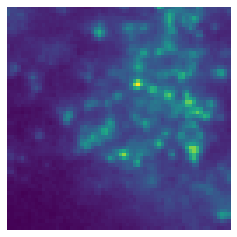

In [26]:
show_image(TRN_IMG_3D_small[0])

### `draw_func`  3D

from arthur:
> The most work will be going from 2D to 3D in the generative model. But the basic principle is rather simple. Right now I have x and y offsets, and the absolute z variable which is treated differently. Now you have 3 offset variables instead which should all be treated the same (except that the PSF width still scales with z). So mostly just copy/paste those lines and add another dimension

Things that need to be adress:

<div class="alert alert-block alert-warning">
<b>1:</b> Normalizing Data before giving to draw function.
</div>

in 2d we use function `get_M` which is responsible for noramalization. `get_M` also takes `dict` which contains `[p_act] = 0.5`  and `[p_lambda] = 0.05`. I guess we dont need them for `mFISH` data since all fluorophores are active?

from arthur

> Well for simulator learning we don't update it, because we don't use any real data The only thing to do is place emitters randomly with a density that is roughly the same as in the actual data we wan't to analyse. So that's why you can just use a constant and keep it like that


In [27]:
M_3D = torch.ones(TRN_IMG_3D_small.shape) - 0.5; M_3D.shape

torch.Size([101, 64, 64])

<div class="alert alert-block alert-warning">
<b>2:</b> shoule we take tanh(z)?
</div>

For `draw_func_3d` we just need to introduce `z_ofsset` which will be `z_os`

In [28]:
def draw_func_3D(M, ll_pars, psf_pars, batch_size=1, local_context=False):
    locs = torch.distributions.Binomial(1, M).sample().to('cuda')
    zeros = torch.zeros_like(locs).to('cuda')
    #should we take for z?
    
    z = torch.distributions.Normal(zeros+ll_pars['z_prior'][0], zeros+ll_pars['z_prior'][1]).sample().to('cuda')
    if '3D' in psf_pars['modality']:
        torch.tanh_(z)
        
    x_os = torch.distributions.Uniform(zeros-0.5, zeros+0.5).sample().to('cuda')
    y_os = torch.distributions.Uniform(zeros-0.5, zeros+0.5).sample().to('cuda')
    z_os = torch.distributions.Uniform(zeros-0.5, zeros+0.5).sample().to('cuda')
    
    ints = torch.distributions.Uniform(torch.zeros_like(locs)+ll_pars['min_int'], torch.ones_like(locs)).sample().to('cuda')

    x_os *= locs
    y_os *= locs
    z_os *= locs
    z *= locs
    ints *= locs
    return locs,x_os,y_os,z_os, z,ints

In [29]:
locs_3d, x_os_3d, y_os_3d, z_os_3d, z_3d, ints_3d, = draw_func_3D(M_3D, LL_PARAMS, PSF_PARAMS, batch_size=110)

In [30]:
list(map(lambda x: getattr(x, 'size')(), [locs_3d, x_os_3d, y_os_3d, z_os_3d, z_3d, ints_3d,]))

[torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64])]

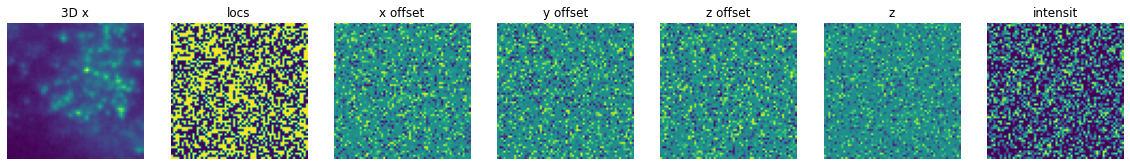

In [31]:
idx = 0
fig, axes = plt.subplots(1, 7, figsize=(20, 20))
show_image(TRN_IMG_3D_small  [idx], title= '3D x'    , ax = axes[0])
show_image(locs_3d           [idx], title= 'locs'    , ax = axes[1])
show_image(x_os_3d           [idx], title= 'x offset', ax = axes[2])
show_image(y_os_3d           [idx], title= 'y offset', ax = axes[3])
show_image(z_os_3d           [idx], title= 'z offset', ax = axes[4])
show_image(z_3d              [idx], title= 'z'       , ax = axes[5])
show_image(ints_3d           [idx], title= 'intensit', ax = axes[6]);

In [37]:
M_3D = torch.tensor(TRN_IMG_3D_small/TRN_IMG_3D_small.max())

In [38]:
TRN_IMG_3D_small.min()

192

In [39]:
locs_3d, x_os_3d, y_os_3d, z_os_3d, z_3d, ints_3d, = draw_func_3D(M_3D, LL_PARAMS, PSF_PARAMS, batch_size=110)
list(map(lambda x: getattr(x, 'size')(), [locs_3d, x_os_3d, y_os_3d, z_os_3d, z_3d, ints_3d,]))

[torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64]),
 torch.Size([101, 64, 64])]

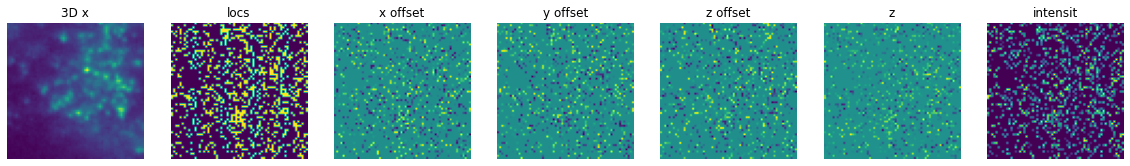

In [40]:
idx = 0
fig, axes = plt.subplots(1, 7, figsize=(20, 20))
show_image(TRN_IMG_3D_small  [idx], title= '3D x'    , ax = axes[0])
show_image(locs_3d           [idx], title= 'locs'    , ax = axes[1])
show_image(x_os_3d           [idx], title= 'x offset', ax = axes[2])
show_image(y_os_3d           [idx], title= 'y offset', ax = axes[3])
show_image(z_os_3d           [idx], title= 'z offset', ax = axes[4])
show_image(z_3d              [idx], title= 'z'       , ax = axes[5])
show_image(ints_3d           [idx], title= 'intensit', ax = axes[6]);

In [36]:
from nbdev.export import *
notebook2script()

Converted 00_models.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
